In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import wfdb
from random import shuffle

import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F

# data preprocessing and extracting
- LUDB data
- https://arxiv.org/pdf/2001.04689.pdf

In [200]:
# folder_path = '/mnt/biosignal_DB/LUDB/physionet.org/files/ludb/1.0.0'
# file_list = os.listdir(folder_path)
# record_list = pd.read_csv(os.path.join(folder_path,'RECORDS')).values.ravel()

In [4]:
# wave_len = 600
# for number,pid in enumerate(record_list):
#     print('{}/{}'.format(number,len(record_list)))
#     record = wfdb.rdrecord(os.path.join(folder_path,str(pid)))
#     atr_ii = wfdb.rdann(os.path.join(folder_path,str(pid)),extension='atr_ii')

#     atr_symbols = np.array(atr_ii.symbol)
#     atr_points = atr_ii.sample
#     lead_II_idx = np.where(np.array(record.sig_name)=='ii')[0][0]
#     lead_II = record.p_signal[:,lead_II_idx]

#     p_onset_list = np.where(np.array(atr_symbols)=='p')[0]-1
    
#     #p를 시작점으로 모든 segment를 자르자.
#     for idx,p_onset in enumerate(p_onset_list):
#         p_idx = atr_points[p_onset]
#         lead_seg = lead_II[p_idx:p_idx+wave_len] ##df에 들어가

#         include_symbols_idx = atr_points[(atr_points>=p_idx)&(atr_points<p_idx+600)]

#         # segments 안에 존재하는 symbol list
#         seg_symbols = atr_symbols[np.isin(atr_points,include_symbols_idx)]
#         # 해당 symbol의 seg ECG 상 실제 위치
#         seg_sybols_idx = include_symbols_idx - p_idx

#         unet_label_list = list()
#         unet_label_list.append(lead_seg)
#         for symbol in ['p','N','t']:
#             # seg_symbol list에서 각 심볼 위치
#             PQRS_seg_symbols = np.where(seg_symbols==symbol)[0]

#             # seg_symbol list에서 p onset 위치
#             Onset_seg_symbols = PQRS_seg_symbols-1
#             Offset_seg_symbols = PQRS_seg_symbols+1

#             dummy = np.zeros(wave_len) #df에 들어가
#             for onset,offset in zip(Onset_seg_symbols,Offset_seg_symbols[:len(Onset_seg_symbols)]):
#                 try:
#                     onset_idx = seg_sybols_idx[onset]
#                     offset_idx = seg_sybols_idx[offset]
#                     dummy[onset_idx:offset_idx] =1
#                 except IndexError:
#                     pass
#             unet_label_list.append(dummy)
        
#         if unet_label_list[-1].sum()!=0: # T가 존재해야지만 저장한다.
#             seg_remain = np.logical_or(unet_label_list[1] ,unet_label_list[2])
#             seg_remain = (np.logical_or(seg_remain,unet_label_list[3])-1)*(-1)
#             unet_label_list.append(seg_remain)
            
#             np.save('../data/segments/{}_{}'.format(pid,idx),np.array(unet_label_list))
           
            
        
    


# segment data load

In [195]:
N=10

1235
13


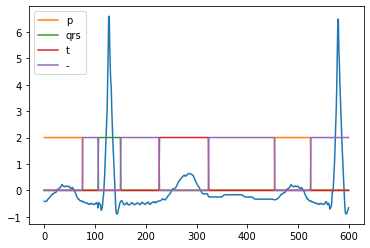

In [199]:
seg_flielist = os.listdir('../data/segments/')
print(len(seg_flielist))

seg_file_df = pd.DataFrame([[filename.split('_')[0],filename]for filename in seg_flielist],columns=['pid','filename'])
seg_file_df = seg_file_df.sort_values(['pid','filename'])
seg_file_df['filepath'] = seg_file_df.filename.apply(lambda x : os.path.join('../data/segments',x))
seg_file_df = seg_file_df[seg_file_df.pid!='.ipynb']

seg = np.load(os.path.join('../data/segments',seg_file_df.filename.tolist()[N]))


plt.plot((seg[0]-np.mean(seg[0]))/np.std(seg[0]))
plt.plot((seg[1]*2),label='p')
plt.plot((seg[2]*2),label='qrs')
plt.plot((seg[3]*2),label='t')
plt.plot(seg[4]*2,label='-')
plt.legend()
print(N)
N+=1

# dataset

In [18]:
class segment_dataset(Dataset):
    def __init__(self,file_df):
        self.filepath = file_df.filepath.tolist()
        
    def __len__(self):
        return len(self.filepath)
    
    def __getitem__(self,item):
        try:
            seg = np.load(self.filepath[item])
            ecg_II = (seg[0]-np.mean(seg[0]))/np.std(seg[0])
            mask_arr = seg[1:,:]
        except:
            print(self.filepath[item])
        
        return torch.from_numpy(ecg_II).unsqueeze(0),torch.from_numpy(mask_arr)
        
        


# model structure

In [19]:
class CBR_1D(nn.Module):
    def __init__(self,in_channels,out_channels,kernel=9,stride=1,padding=4):
        super().__init__()
        self.seq_list = [
        nn.Conv1d(in_channels,out_channels,kernel,stride,padding,bias=False),
        nn.BatchNorm1d(out_channels),
        nn.ReLU()]
        
        self.seq = nn.Sequential(*self.seq_list)
        
    def forward(self,x):
        return self.seq(x)


In [20]:
# class Unet_1D(nn.Module):
#     def __init__(self,class_n):
#         super().__init__()
        
#         ### ------- encoder -----------
#         self.enc1_1 = CBR_1D(1,4)
#         self.enc1_2 = CBR_1D(4,4)
#         self.enc1_3 = CBR_1D(4,4)
        
#         self.enc2_1 = CBR_1D(4,8)
#         self.enc2_2 = CBR_1D(8,8)
        
#         self.enc3_1 = CBR_1D(8,16)
#         self.enc3_2 = CBR_1D(16,16)
        
#         self.enc4_1 = CBR_1D(16,32)
#         self.enc4_2 = CBR_1D(32,32)
        
# #         self.enc5_1 = CBR_1D(32,64)
# #         self.enc5_2 = CBR_1D(64,64)
        
# #         self.upsample_1 = nn.ConvTranspose1d(kernel_size=8,stride=2,padding=3)
# #         self.dec4_1 = CBR_1D(32+64,32)
# #         self.dec4_2 = CBR_1D(32,32)
        
#         ### ------- decoder -----------
#         self.upsample_3 = nn.ConvTranspose1d(32,32,kernel_size=8,stride=2,padding=3)
#         self.dec3_1 = CBR_1D(16+32,16)
#         self.dec3_2 = CBR_1D(16,16)
        
#         self.upsample_2 = nn.ConvTranspose1d(16,16,kernel_size=8,stride=2,padding=3)
#         self.dec2_1 = CBR_1D(8+16,8)
#         self.dec2_2 = CBR_1D(8,8)
        
#         self.upsample_1 = nn.ConvTranspose1d(8,8,kernel_size=8,stride=2,padding=3)
#         self.dec1_1 = CBR_1D(4+8,4)
#         self.dec1_2 = CBR_1D(4,4)
#         self.dec1_3 = CBR_1D(4,4)
#         self.dec1_4 = CBR_1D(4,class_n)
        
#     def forward(self,x):
        
#         enc1 = self.enc1_1(x)
#         enc1 = self.enc1_2(enc1)
#         enc1 = self.enc1_3(enc1)
        
#         enc2 = nn.functional.max_pool1d(enc1,2)
#         enc2 = self.enc2_1(enc2)
#         enc2 = self.enc2_2(enc2)
        
#         enc3 = nn.functional.max_pool1d(enc2,2)
#         enc3 = self.enc3_1(enc3)
#         enc3 = self.enc3_2(enc3)
        
#         enc4 = nn.functional.max_pool1d(enc3,2)        
#         enc4 = self.enc4_1(enc4)
#         enc4 = self.enc4_2(enc4)
        
#         dec3 = self.upsample_3(enc4)
#         dec3 = self.dec3_1(torch.cat([enc3,dec3],dim=1))
#         dec3 = self.dec3_2(dec3)
        
#         dec2 = self.upsample_2(dec3)
#         dec2 = self.dec2_1(torch.cat([enc2,dec2],dim=1))
#         dec2 = self.dec2_2(dec2)
        
#         dec1 = self.upsample_1(dec2)
#         dec1 = self.dec1_1(torch.cat([enc1,dec1],dim=1))
#         dec1 = self.dec1_2(dec1)
#         dec1 = self.dec1_3(dec1)
#         out = self.dec1_4(dec1)
        
#         return out

In [212]:
class Unet_1D(nn.Module):
    def __init__(self,class_n,layer_n):
        super().__init__()
        
        ### ------- encoder -----------
        self.enc1_1 = CBR_1D(1,layer_n)
        self.enc1_2 = CBR_1D(layer_n,layer_n)
        self.enc1_3 = CBR_1D(layer_n,layer_n)
        
        self.enc2_1 = CBR_1D(layer_n,layer_n*2)
        self.enc2_2 = CBR_1D(layer_n*2,layer_n*2)
        
        self.enc3_1 = CBR_1D(layer_n*2,layer_n*4)
        self.enc3_2 = CBR_1D(layer_n*4,layer_n*4)
        
        self.enc4_1 = CBR_1D(layer_n*4,layer_n*8)
        self.enc4_2 = CBR_1D(layer_n*8,layer_n*8)
        
#         self.enc5_1 = CBR_1D(32,64)
#         self.enc5_2 = CBR_1D(64,64)
        
#         self.upsample_1 = nn.ConvTranspose1d(kernel_size=8,stride=2,padding=3)
#         self.dec4_1 = CBR_1D(32+64,32)
#         self.dec4_2 = CBR_1D(32,32)
        
        ### ------- decoder -----------
        self.upsample_3 = nn.ConvTranspose1d(layer_n*8,layer_n*8,kernel_size=8,stride=2,padding=3)
        self.dec3_1 = CBR_1D(layer_n*4+layer_n*8,layer_n*4)
        self.dec3_2 = CBR_1D(layer_n*4,layer_n*4)
        
        self.upsample_2 = nn.ConvTranspose1d(layer_n*4,layer_n*4,kernel_size=8,stride=2,padding=3)
        self.dec2_1 = CBR_1D(layer_n*2+layer_n*4,layer_n*2)
        self.dec2_2 = CBR_1D(layer_n*2,layer_n*2)
        
        self.upsample_1 = nn.ConvTranspose1d(layer_n*2,layer_n*2,kernel_size=8,stride=2,padding=3)
        self.dec1_1 = CBR_1D(layer_n*1+layer_n*2,layer_n*1)
        self.dec1_2 = CBR_1D(layer_n*1,layer_n*1)
        self.dec1_3 = CBR_1D(layer_n*1,class_n)
        self.dec1_4 = CBR_1D(class_n,class_n)
        
    def forward(self,x):
        
        enc1 = self.enc1_1(x)
        enc1 = self.enc1_2(enc1)
        enc1 = self.enc1_3(enc1)
        
        enc2 = nn.functional.max_pool1d(enc1,2)
        enc2 = self.enc2_1(enc2)
        enc2 = self.enc2_2(enc2)
        
        enc3 = nn.functional.max_pool1d(enc2,2)
        enc3 = self.enc3_1(enc3)
        enc3 = self.enc3_2(enc3)
        
        enc4 = nn.functional.max_pool1d(enc3,2)        
        enc4 = self.enc4_1(enc4)
        enc4 = self.enc4_2(enc4)
        
        dec3 = self.upsample_3(enc4)
        dec3 = self.dec3_1(torch.cat([enc3,dec3],dim=1))
        dec3 = self.dec3_2(dec3)
        
        dec2 = self.upsample_2(dec3)
        dec2 = self.dec2_1(torch.cat([enc2,dec2],dim=1))
        dec2 = self.dec2_2(dec2)
        
        dec1 = self.upsample_1(dec2)
        dec1 = self.dec1_1(torch.cat([enc1,dec1],dim=1))
        dec1 = self.dec1_2(dec1)
        dec1 = self.dec1_3(dec1)
        out = self.dec1_4(dec1)
        
        return out

# Train

In [213]:
## hyper parameter
device = 'cuda:1'
class_n = 2
total_epoch = 300

lr = 0.001
batch_size = 256

In [214]:
pid_list = list(set(seg_file_df.pid.tolist()))
shuffle(pid_list)

tr_pid_list = pid_list[:int(len(pid_list)*(3/4))]
vd_pid_list = pid_list[int(len(pid_list)*(3/4)):]

tr_file_df = seg_file_df.query("pid in @tr_pid_list")
vd_file_df = seg_file_df.query("pid in @vd_pid_list")

tr_dataset = segment_dataset(tr_file_df)
vd_dataset = segment_dataset(vd_file_df)

tr_loader = DataLoader(tr_dataset,batch_size=batch_size,shuffle=True,drop_last=True)
vd_loader = DataLoader(vd_dataset,batch_size=batch_size)

In [215]:
from torch.optim.lr_scheduler import CosineAnnealingLR,StepLR,ReduceLROnPlateau

model = Unet_1D(4,6).double().to(device)
optim = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optim,'min',patience=10,factor=0.8,min_lr=1e-8)
loss_f = torch.nn.BCEWithLogitsLoss()

In [216]:
#tr_output_list = list()
for epoch in range(total_epoch):
    model.train()
    train_loss = 0
    tr_output_list = list()
    for idx,(X,y) in enumerate(tr_loader):
        optim.zero_grad()
        
        y_pred = model(X.to(device))
        loss = loss_f(y_pred,y.to(device))
        
        loss.backward()
        optim.step()
        
        train_loss+=loss.cpu().item()/len(tr_loader)
        out_pred = F.softmax(y_pred,1).detach().cpu().numpy().argmax(axis=1)
        tr_output_list.extend(list(out_pred))
        
    print("------------- {} epoch-------------".format(epoch))
    print("Train loss : {:.3f}".format(train_loss))
    
    vd_loss = 0
    for idx,(X,y) in enumerate(vd_loader):

        y_pred = model(X.to(device))
        out_pred = F.softmax(y_pred,1).detach().cpu().numpy().argmax(axis=1)
        
        loss = loss_f(y_pred,y.to(device))
        vd_loss+=loss.cpu().item()/len(vd_loader)
    print("Valid loss : {:.3f}".format(vd_loss))



------------- 0 epoch-------------
Train loss : 0.779
Valid loss : 0.753
------------- 1 epoch-------------
Train loss : 0.746
Valid loss : 0.733
------------- 2 epoch-------------
Train loss : 0.727
Valid loss : 0.717
------------- 3 epoch-------------
Train loss : 0.712
Valid loss : 0.701
------------- 4 epoch-------------
Train loss : 0.695
Valid loss : 0.691
------------- 5 epoch-------------
Train loss : 0.687
Valid loss : 0.685
------------- 6 epoch-------------
Train loss : 0.682
Valid loss : 0.683
------------- 7 epoch-------------
Train loss : 0.679
Valid loss : 0.680
------------- 8 epoch-------------
Train loss : 0.676
Valid loss : 0.678
------------- 9 epoch-------------
Train loss : 0.675
Valid loss : 0.676
------------- 10 epoch-------------
Train loss : 0.673
Valid loss : 0.674
------------- 11 epoch-------------
Train loss : 0.671
Valid loss : 0.672
------------- 12 epoch-------------
Train loss : 0.669
Valid loss : 0.671
------------- 13 epoch-------------
Train loss :

KeyboardInterrupt: 

In [217]:
vd_ecg_list = list()
vd_label_list = list()
vd_output_list = list()
for idx,(X,y) in enumerate(vd_loader):

    y_pred = model(X.to(device))
    out_pred = F.softmax(y_pred,1).detach().cpu().numpy().argmax(axis=1)
    
    vd_output_list.extend(list(out_pred))
    vd_ecg_list.extend(list(X.cpu().detach().numpy().squeeze(1)))
    vd_label_list.extend(list(y.cpu().detach().numpy()))

In [218]:
from scipy.stats import mode
def output_sliding_voting(output,window=5):
    # window size must be odd number
    output = pd.Series(output).rolling(window).apply(lambda x : mode(x)[0][0]).fillna(method='bfill')
    return output.values

183


/home/jjong/anaconda3/envs/torch_v1.3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  after removing the cwd from sys.path.


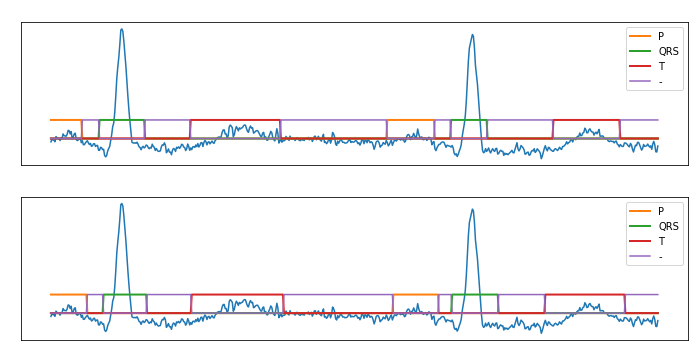

In [242]:
sample_n = np.random.randint(0,len(vd_ecg_list))
print(sample_n)
ecg = vd_ecg_list[sample_n]
label = vd_label_list[sample_n]

output = vd_output_list[sample_n]
output = output_sliding_voting(output,7)

p = (output == 0)
N = (output == 1)
t = (output == 2)
r = (output == 3)


with plt.rc_context({'xtick.color':'white','ytick.color':'white'}):
    
    fig,axes = plt.subplots(2,1,figsize=(10,5))
    fig.tight_layout()
    
    axes[0].set_title("True boundary",color='white')
    axes[0].plot(ecg)
    axes[0].plot(label[0],label='P',linewidth=2)
    axes[0].legend(loc="upper right")
    axes[0].plot(label[1],label='QRS',linewidth=2)
    axes[0].plot(label[2],label='T',linewidth=2)
    axes[0].plot(label[3],label='-')
    axes[0].legend(loc="upper right")

    axes[1].set_title('Deep learnig Segmentation',color='white')
    axes[1].plot(ecg)
    axes[1].plot(p,label='P',linewidth=2)
    axes[1].plot(N,label='QRS',linewidth=2)
    axes[1].plot(t,label='T',linewidth=2)
    axes[1].plot(r,label='-')
    axes[1].legend(loc="upper right")